In [1]:
import numpy as np
import os
import pdb
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
import pickle
import pandas as pd
import seaborn as sns
from scipy import stats
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
import yaml
import config
import utils.online_metrics
from utils.ztools import ZStructTranslator, getZFeats, sliceMiddleTrials
from utils import offline_training, nn_decoders, offline_metrics
from utils.offline_data import datacleanup, splitOfflineData


In [2]:
#setup pytorch stuff
device = torch.device('cuda:0')
dtype = torch.float

## Load in saved data
date = '2021-02-16'
print('loading data')
with open(os.path.join(config.data_dir,'fits_offline',f'data_{date}.pkl'), 'rb') as f:
    trainData, testData, inIDXList, outIDXList, trial_num = pickle.load(f)

loading data


In [ ]:
nn_models = []
scalers = []
numFolds = 5
for k in np.arange(numFolds):
    neu = torch.from_numpy(trainData['neu3D'][k]).to(device, dtype)
    vel = torch.from_numpy(trainData['vel'][k]).to(device, dtype)

    neu_mean, neu_std = neu.mean(axis=0), neu.std(axis=0)
    vel_mean, vel_std = vel.mean(axis=0), vel.std(axis=0)
    #create pytorch datasets and then dataloaders
    ds = TensorDataset(neu, vel)

    #since we know how long we're training, val dataset can just be the same as training
    dl = DataLoader(ds, batch_size=config.batch_size, shuffle=True, drop_last=True)
    dl2 = DataLoader(ds, batch_size=len(ds), shuffle=False, drop_last=True)

    #Model Instance and architecture
    in_size = neu.shape[1]
    num_states = 2

    model = offline_training.init_model(nn_decoders.RecurrentModel, 'LSTM_xnorm_ynorm', in_size, num_states)
    opt, scheduler = offline_training.init_opt(model, 'LSTM_xnorm_ynorm')

    #run fit function (model is trained here)
    _, _, _ = offline_training.fit(model,
                                    'LSTM_xnorm_ynorm',
                                    opt,
                                    scheduler,
                                    dl,
                                    dl2)
    #train scaler
    dl_scale = DataLoader(ds, batch_size=len(ds), shuffle=True)
    scalers.append(offline_training.generate_output_scaler(model, dl_scale, num_outputs=num_states))
    model = model.cpu()
    nn_models.append(model)

print(f'tcFNN models trained.')
# save decoders and scalers
with open(os.path.join(config.model_dir, 'fits_offline', f'tcFNNmodels_{date}.pkl'), 'wb') as f:
    pickle.dump((nn_models, scalers), f)
print('tcFNN models Saved')

steppin
0.0002
steppin
0.0002
Epoch [0/99], iter 192 Validation Loss: 0.0010
steppin
0.0002
steppin
0.0002
Epoch [1/99], iter 385 Validation Loss: 0.0009
steppin
0.0002
steppin
0.0002
Epoch [2/99], iter 578 Validation Loss: 0.0009
steppin
0.0002
steppin
0.0002
Epoch [3/99], iter 771 Validation Loss: 0.0009
steppin
0.0002
steppin
0.0002
Epoch [4/99], iter 964 Validation Loss: 0.0009
steppin
0.0002
steppin
0.0002
Epoch [5/99], iter 1157 Validation Loss: 0.0009
steppin
0.0002
steppin
0.0002
Epoch [6/99], iter 1350 Validation Loss: 0.0008
steppin
0.0002
steppin
0.0002
Epoch [7/99], iter 1543 Validation Loss: 0.0008
steppin
0.0002
steppin
0.0002
Epoch [8/99], iter 1736 Validation Loss: 0.0008
steppin
0.0002
steppin
0.0002
Epoch [9/99], iter 1929 Validation Loss: 0.0008
steppin
0.0002
steppin
0.0002
Epoch [10/99], iter 2122 Validation Loss: 0.0008
steppin
0.0002
steppin
0.0002
Epoch [11/99], iter 2315 Validation Loss: 0.0008
steppin
0.0002
steppin
0.0002
Epoch [12/99], iter 2508 Validation L

In [14]:
# Get predictions for each decoder
nn_predictions = np.zeros((testData['vel'].shape[0], testData['vel'].shape[1], numFolds))
for i in range(numFolds):
    tcfnn = nn_models[i].to(device)
    tcfnnscaler = scalers[i]

    tcfnn.eval()

    neu3 = torch.from_numpy(testData['neu3D']).to(device, dtype)
    yh = tcfnn(neu3)
    if isinstance(yh, tuple):
        # RNNs return y, h
        yh = yh[0]

    nn_predictions[:,:,i] = tcfnnscaler.scale(yh).cpu().detach().numpy()

#scale predictions for au/sec
binsize = config.binsize
sec = 1000

nn_predictions = nn_predictions/binsize * sec
vel_test = testData['vel']/binsize * sec

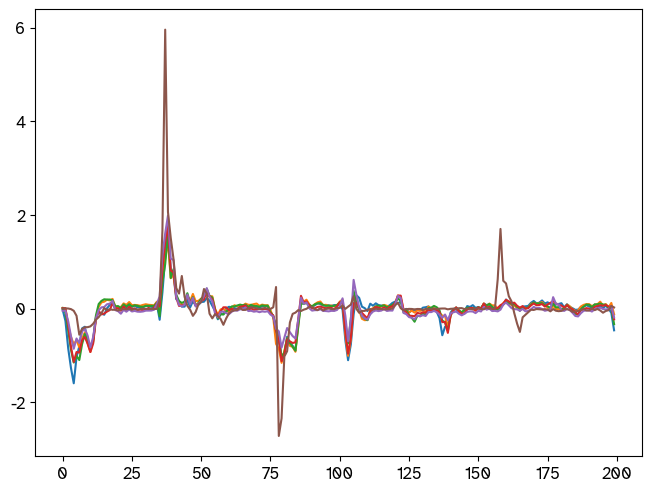

In [18]:
plt.plot(nn_predictions[0:200,0,:])
plt.plot(vel_test[0:200,0])